# Solar fundamentals

## Creating the scene to compute view factors of sky-panel

In [2]:
import pyvista as pviz
from datetime import datetime, timezone, timedelta
import sys
import numpy as np
sys.path.append('../../python/')
from egb351.collector_geometry import flat_panel_unit_vectors, sky_view_factor
from egb351.math import cosd, sind
from egb351.sun import solar_vector_from_angles, sun_path_diagram
# pviz.set_jupyter_backend('trame') 

In [3]:
β,γ = 0,180-43
h,w = 1.6,1.0
H,W = 20.0,15.0
x0p = 10
sky_rad = 100
wall_rotation = 43
n,u,v = flat_panel_unit_vectors(β,γ)
n_wall = np.array([sind(wall_rotation),-cosd(wall_rotation),0]) # wall orientation (zero corresponds to a face that is due north)
x0,y0,z0 = x0p*n_wall + np.array([0,0,-h/2*u[-1]])

In [4]:
array = pviz.Plane(i_size=w,j_size=h,i_resolution=1,j_resolution=1)
wall = pviz.Plane(center=(0,0,H/2),direction=n_wall,i_size=H,j_size=W,i_resolution=1,j_resolution=1)
sky = pviz.Sphere(center=(x0,y0,z0),start_phi=0,end_phi=90,radius=sky_rad,phi_resolution=20,theta_resolution=20)
sky.flip_normals() # normals of cells point in
print(f"Area of panel: {array.area}")

Area of panel: 1.600000023841858


In [5]:
array.rotate_x(β,inplace=True)
array.rotate_vector([0,0,1],-γ,inplace=True)
array.translate([x0,y0,z0],inplace=True)

PolyData (0x7ff4ae07ac80)
  N Cells:    1
  N Points:   4
  N Strips:   0
  X Bounds:   5.909e+00, 7.731e+00
  Y Bounds:   -8.240e+00, -6.387e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   2

In [6]:
np.dot(array.cell_normals,n) # should be one if it aligns with the expected normal

pyvista_ndarray([1.])

In [7]:
array.points

pyvista_ndarray([[ 6.640062 , -6.387455 ,  0.       ],
                 [ 5.908708 , -7.0694532,  0.       ],
                 [ 7.7312593, -7.557621 ,  0.       ],
                 [ 6.9999056, -8.239619 ,  0.       ]], dtype=float32)

In [8]:
obstacles = pviz.MultiBlock([wall])

/home/cholettm/OneDrive/egb351/code/.venv/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


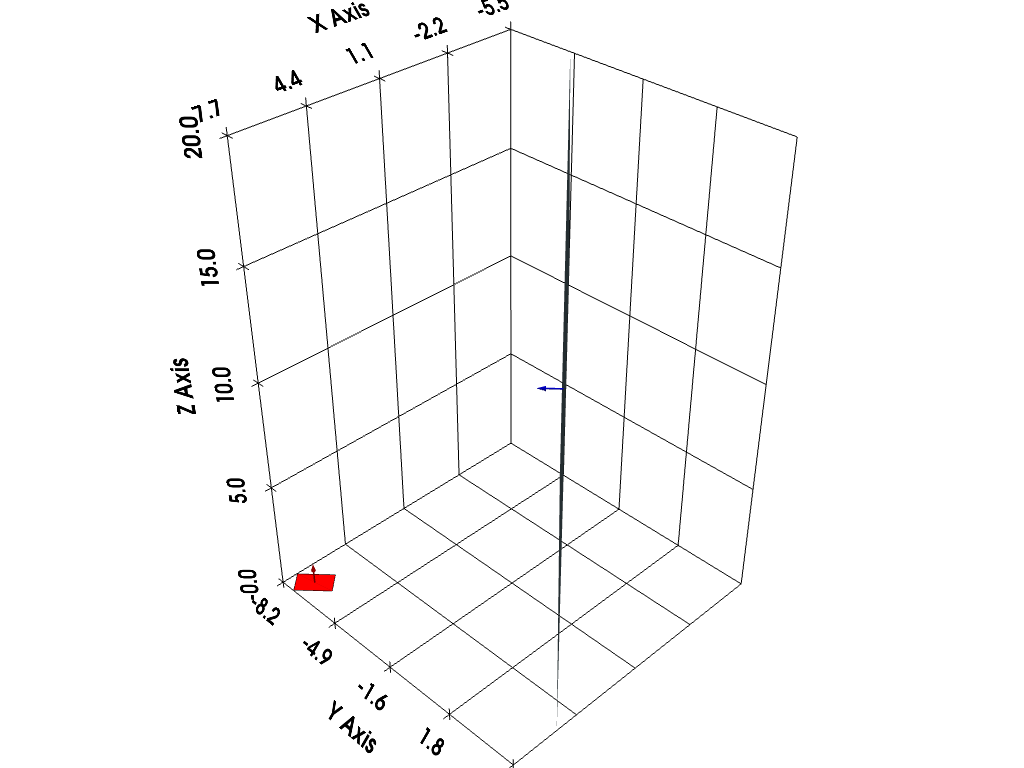

In [9]:
pl = pviz.Plotter()
pl.add_mesh(array,show_edges=True,color="red",lighting=False)
# pl.add_mesh(wall)
pl.add_mesh(obstacles)
pl.add_arrows(array.cell_centers().points, array.cell_normals, mag=1, color='red')
pl.add_arrows(wall.cell_centers().points, wall.cell_normals, mag=1, color='blue')
pl.show_grid()
# pl.view_xy()
pl.show()

/home/cholettm/OneDrive/egb351/code/.venv/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


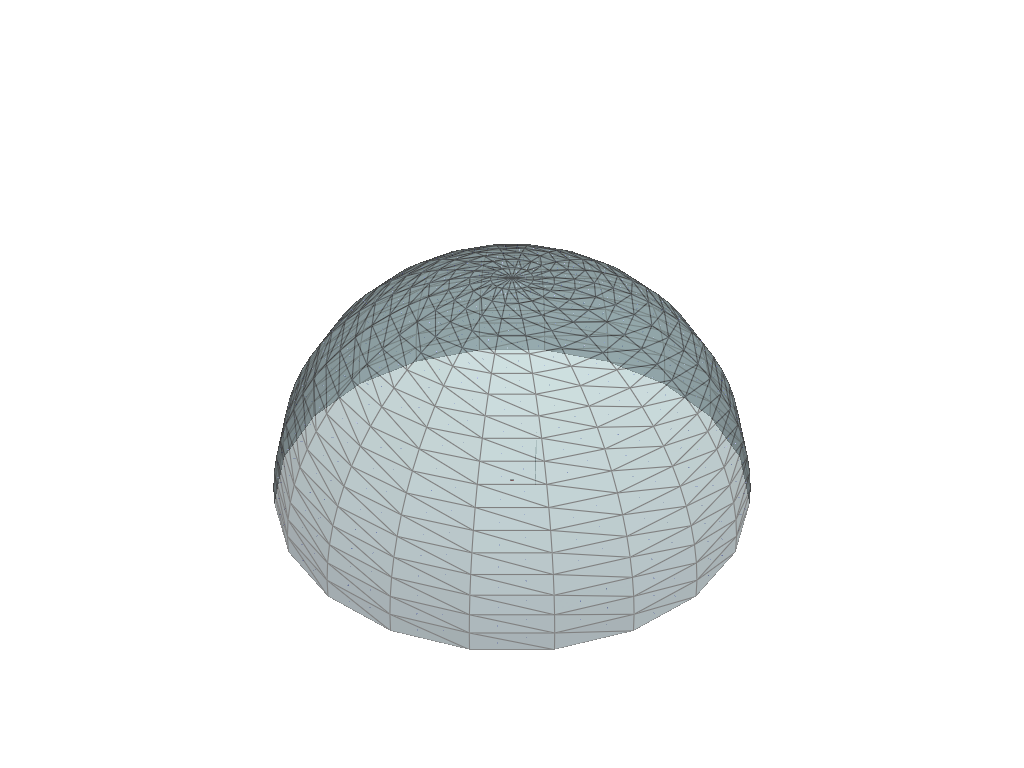

In [10]:
pl = pviz.Plotter()
pl.add_mesh(array,show_edges=True,color="red",lighting=False)
pl.add_mesh(obstacles)
pl.add_mesh(sky,opacity=0.5,show_edges=True)
pl.add_arrows(sky.cell_centers().points, sky.cell_normals, mag=1, color='blue')
pl.add_arrows(array.cell_centers().points, array.cell_normals, mag=1, color='red')
pl.show()

## Compute view factor from sky-array
The wall is set as an obstruction

In [11]:
F = sky_view_factor(array,obstacles,sky)

 69%|██████▉   | 512/740 [00:19<00:06, 37.41it/s]

In [ ]:
Fsa = F.sum(axis=1)
sky.cell_data['Panel View Factor'] = Fsa
sky.cell_data['Blocked'] = np.float64(Fsa==0.0)

In [ ]:
print(f"Sky view factor (pyViewFactor): {Fsa.sum():.3e}")
print(f"Sky view factor (analytical): {0.5*(1+np.cos(np.deg2rad(β))):.3e}")
print(f"Bs factor: {Fsa.sum()/(0.5*(1+np.cos(np.deg2rad(β)))):.3e}")

In [ ]:
pl = pviz.Plotter()
pl.add_mesh(array,show_edges=True,color="red",lighting=False)
pl.add_mesh(wall)
pl.add_mesh(sky,scalars="Panel View Factor",show_edges=True,opacity=1.0)
pl.show()

In [ ]:
pl = pviz.Plotter()
pl.add_mesh(array,show_edges=True,color="red",lighting=False)
pl.add_mesh(obstacles)
pl.add_mesh(sky,scalars="Blocked",show_edges=False,opacity=0.25)
v = -array.cell_normals[0]
pl.show()

## Computing view factors for different $\beta$ and $\gamma$ combinations for a particular x0

In [ ]:
n_tilt = 20
n_az = 20
tilt_grid = np.linspace(0,90,n_tilt)
az_grid = np.linspace(-180,180,n_az)
Bs = np.zeros((n_tilt,n_az))
for ii,b in enumerate(tilt_grid):
    for jj,g in enumerate(az_grid):
        na,_,_ = flat_panel_unit_vectors(b,g)
        array = pviz.Plane(center=(x0,y0,z0),direction=na,i_size=h,j_size=w,i_resolution=1,j_resolution=1)
        F = sky_view_factor(array,obstacles,sky)
        no_obstruct_vf = 0.5*(1+cosd(b))
        if b==0:
            Bs[ii,:] = F.sum()/no_obstruct_vf
            break
        else:
            Bs[ii,jj] = F.sum()/no_obstruct_vf

        # print(fr"VF for β={b:.1f},γ={g:.1f}: {vfs[ii,jj]:.3e}")

Visualization of the Bs factors

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
tilt_grid = np.linspace(0,90,n_tilt)
az_grid = np.linspace(-180,180,n_az)
x,y = np.meshgrid(tilt_grid,az_grid)

fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x,y,Bs,cmap=cm.coolwarm)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\gamma$')
ax.set_zlabel(r'$B_s$')

fig,ax = plt.subplots()
CS = ax.contour(x,y,Bs,cmap=cm.coolwarm)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\gamma$')
ax.set_xlim((-5,95))
ax.set_ylim((-195,195))
ax.set_title(rf"$B_s$ for at distance of $x_0$={x0p:.1f} from the wall")

Export to an excel file

In [ ]:
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
tilt_grid = np.linspace(0,90,n_tilt)
az_grid = np.linspace(-180,180,n_az)
values = np.hstack([Bs,Bs[:,1][:,np.newaxis]])
cols = np.hstack([az_grid,az_grid[-1] + (az_grid[-1]+az_grid[1])])

df = pd.DataFrame(values,index=tilt_grid,columns=cols)
df.to_excel('outputs/bs_lookups.xlsx')

xg,yg = np.meshgrid(df.index,df.columns)
fun = RegularGridInterpolator((df.index,df.columns),df.values)
fun((20,180))

## Assess sun positions that are blocked
Note that [Wikipedia was helpful](https://en.wikipedia.org/wiki/Line%E2%80%93plane_intersection). We parameterize the wall plane as
$$ (\vec{p}-\vec{p}_0)\cdot \vec{n}_{wall}$$
where $n_{wall}$ is the plane normal, $p$ is an (unknown) point on the plane, and $p_0$ is a known point on the plane. The test line is parameterized as 
$$ \vec{p} = \vec{\ell}_0 + d\, \vec{n}_{sun} $$
where $\vec{\ell}_0$ is the center of the array and $\vec{n}_{sun}$ is a vector that points from the array centre to the sun. Here, $d \in \mathbb{R}$ is a scalar that is positive if the plane intersection is in front of the plane and negative if it is behind the plane. We can set these two expressions equal to each other and solve for $d$ to obtain
$$ (\vec{\ell}_0 + d\, \vec{n}_{sun}- \vec{p}_0)\cdot \vec{n}_{wall} = 0 \\[2ex]
   d = \frac{(\vec{p}_0-\vec{\ell}_0)\cdot \vec{n}_{wall}}{\vec{n}_{sun}\cdot \vec{n}_{wall}}
$$



In [ ]:
p0 = np.array([0,0,0])
L0 = np.array([x0,y0,z0])
nz,na = 50,100
sun_zenith_grid = np.linspace(0,90,nz)
sun_azimuth_grid = np.linspace(-180,180,na)
blocked = np.zeros((nz,na))
Rz = np.array([ [cosd(60),sind(60),0],
                [-sind(60),cosd(60),0],
                [0,0,1]])
bnds = Rz@np.array([0,W/2,H])
for ii,z in enumerate(sun_zenith_grid):
    for jj,a in enumerate(sun_azimuth_grid):
        n_sun = solar_vector_from_angles(a,z,convention='sam')
        d = np.dot((p0-L0),n_wall)/np.dot(n_sun,n_wall)
        if d > 0:
            p = L0 + d*n_sun
            if ( np.abs(p[1]) <= bnds[1] ) & (p[2] < bnds[2]):
                blocked[ii,jj] = 1

blocked.sum()

In [ ]:
z,a = np.meshgrid(sun_zenith_grid,sun_azimuth_grid)
X = sky_rad*sind(z)*sind(-a)
Y = -sky_rad*sind(z)*cosd(-a)
Z = sky_rad*cosd(z)
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(X,Y,Z,c=blocked.T) 
ax.view_init(azim=180)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [ ]:
row,col = np.where(blocked==1)
zeniths_blocked = 90*np.ones_like(sun_azimuth_grid)
uc = np.unique(col)
for ii,cc in enumerate(sun_azimuth_grid):
    if ii in col:
        idx = row[col==ii].min()
        zeniths_blocked[ii] = sun_zenith_grid[idx]

location_name = "Brisbane, Australia"
lat = -27.4705
lon_st = 360-150 # E -> subtract from 360
lon = 360-153.0260 # E -> subtract from 360
utc_offset = 10

summer_solstice = datetime(2024,6,20)
winter_solstice = datetime(2024,12,21)
dts = [summer_solstice,winter_solstice]
dts_of_interest = np.array([dt.timetuple().tm_yday for dt in dts],dtype=np.float64)  # day of year
doy_grid = np.arange(0,366,36,dtype=np.float64)

for d in dts_of_interest:
    if np.abs(doy_grid-d).min() < 10:   
        idx = np.abs(doy_grid-d).argmin()
        doy_grid = np.delete(doy_grid,idx)
    doy_grid = np.r_[doy_grid,d]
doy_grid = np.sort(doy_grid)

hod_grid = np.arange(3,22,0.1)
year = datetime.now().year
dt0 = datetime(year,1,1,0,0,0,tzinfo=timezone(timedelta(hours=utc_offset)))
out = sun_path_diagram(dt0,hod_grid,doy_grid,lat,lon,lon_st,force_south_as_zero=False,location_name=location_name)
fig,ax = out['figure_handle'],out['axis_handle']


if out['data']['azimuth_zero']== 'North':
    az_grid = []
    for γ in sun_azimuth_grid:
        if γ<0: # east of north
            az_grid.append(-180 - γ)
        else: # west of north
            az_grid.append(180 - γ)
else:
    az_grid = sun_azimuth_grid

ax.fill_between(x=az_grid,y1=90-zeniths_blocked,y2=np.zeros_like(zeniths_blocked),alpha=0.75,zorder=10,label='blocked by wall')
ax.set_ylim((0,90))
ax.set_xlim((-180,180))
fig.tight_layout()
ax.legend()

In [ ]:
df = pd.DataFrame(blocked,index=sun_zenith_grid,columns=sun_azimuth_grid)
df.to_excel('outputs/blocked.xlsx')